In [ ]:
import torch
from torch.utils.data import TensorDataset
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torch
import torch.nn.functional as F

def random_extract(feat, t_max):
    r = torch.randint(len(feat) - t_max, size=(1,))
    return feat[r:r+t_max]

def uniform_extract(feat, t_max):
    r = torch.linspace(0, len(feat) - 1, t_max, dtype=torch.float32)
    r = r.to(dtype=torch.long)
    return feat[r, :]

def pad(feat, min_len):
    if feat.size(0) <= min_len:
        pad_size = (0, min_len - feat.size(0))
        return F.pad(feat, (0, 0) + pad_size, mode='constant', value=0)
    else:
        return feat

def process_feat(feat, length, is_random=True):
    feat = torch.tensor(feat)

    if len(feat) > length:
        if is_random:
            return random_extract(feat, length)
        else:
            return uniform_extract(feat, length)
    else:
        return pad(feat, length)

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np

class Dataset(Dataset):
    def __init__(self, transform=None, test_mode=False):
        self.test_mode = test_mode
        self.dataset_dir = "E:/DSA/featurestrn"
        self.normal_flag = "Normal_"
        self._parse_list()

    def _parse_list(self):
        self.list = [os.path.join(self.dataset_dir, f) for f in os.listdir(self.dataset_dir) if f.endswith('.pt')]

    def __getitem__(self, index):
        if self.normal_flag in self.list[index]:
            label = 0.0
        else:
            label = 1.0

        features = torch.load(self.list[index]).to(torch.float32)
        
        if self.test_mode:
            return features
        else:
            features = process_feat(features, 128, is_random=False)
            return features, label

    def __len__(self):
        return len(self.list)

In [ ]:
data = Dataset()

In [ ]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(data, test_size=0.2, random_state=42, shuffle = True)
val, test = train_test_split(val, test_size=0.4, random_state=42, shuffle = True)

train_loader = torch.utils.data.DataLoader(train, batch_size=32, num_workers=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=32, num_workers=2, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, num_workers=2, shuffle=True)

C:\Users\CDI_1V\AppData\Local\Temp\ipykernel_14552\757086875.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feat = torch.tensor(feat)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

class SelfAttentionXFA(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttentionXFA, self).__init__()
        self.query = nn.Linear(in_features=250, out_features=250)
        self.key = nn.Linear(in_features = 250, out_features =250)
        self.value = nn.Linear(in_features = 250, out_features =250)
        self.Wc = torch.nn.Conv2d(1,1,kernel_size=(1, 250))

    def forward(self,x):
        # Compute Query, Key, and Value matrices
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        bacth = x.shape[0]

        Wf = torch.nn.Conv2d(1,1,kernel_size=(1, bacth))
        # PART 1 - NORMALIZATION

        # L2 normalization along the feature dimension
        q_norm = q / torch.norm(q, dim=1, keepdim=True, p=2)
        k_norm = k / torch.norm(k, dim=1, keepdim=True, p=2)


        # PART 2 - CALCULATION FOR kc_hat AND kf_hat

        # kc_hat
        k_norm = k_norm.view(-1,1,1,250)

        kc_hat = self.Wc(k_norm)

        kc_hat = kc_hat.view(-1,1)

        # kf_hat

        k_norm = k_norm.view(-1,250)
        k_norm_t = k_norm.t()

        k_norm = k_norm_t.view(250,1,1,-1)

        kf_hat = Wf(k_norm)

        kf_hat = kf_hat.view(-1,1)
        kf_hat = kf_hat.t()

        # PART 3 - MATRIX MULTIPLICATION : XFA(Q, K, V) = VλQˆT Kˆf Kˆc

        temperature = 0.001

#         multiplying all the matrices
        mat1 = v*temperature
        q_norm_t = q_norm.t()
        mat2 = torch.matmul(mat1,q_norm_t)
        mat3 = torch.matmul(mat2,kc_hat)
        x = torch.matmul(mat3,kf_hat)
        return x

# CRF layer is used to model label dependencies and relationships in structured prediction tasks.
# Data flows through this layer by computing unary and pairwise energies, transforming them based on label compatibilities,
# and iteratively updating the marginal distribution to produce the final output.
class ConditionalRandomFields(nn.Module):
    def __init__(self, size):
        super(ConditionalRandomFields, self).__init__()
        self.size = size
        self.unary_energy = nn.Linear(size, 250).to(device)
        self.pairwise_energy = nn.Linear(size, 250).to(device)

        #This is a learnable parameter that represents the compatibility between labels.
        #It is a square matrix of size `(self.size, self.size)`. It is initialized with random values between -1 and 1 using uniform initialization
        self.compatibility_matrix = nn.Parameter(torch.Tensor(size, size)).to(device)
        self.ln1 = nn.LayerNorm(250)
        # Initialize compatibility matrix with random values
        nn.init.uniform_(self.compatibility_matrix, -1, 2)

    #computes the unary energy for each element in the sequence using the `self.unary_energy` linear layer.
    #This energy represents the model's confidence in assigning each label to each element independently.
    def compute_unary_energy(self, bi):
        return self.unary_energy(bi)

    #`H` represents some energy values (possibly computed from a previous step).
    #`It computes the pairwise energy between labels for each element in the sequence using the `self.pairwise_energy` linear layer
    def compute_pairwise_energy(self, H):
        return self.pairwise_energy(H)

    #performs a matrix multiplication with the learnable `self.compatibility_matrix`.
    #this step transforms the pairwise energy values based on the compatibility between labels
    def compatibility_transform(self, Ep):
        return torch.matmul(Ep, self.compatibility_matrix)

    def forward(self, bi):
        # Step 3: Initialize marginal distribution by unary energy
        #Initialize the marginal distribution `E` by computing the unary energy `Eu` using `compute_unary_energy`.
        Eu = self.compute_unary_energy(bi).to(device)
        E = Eu.to(device)
        for _ in range(5):
            # Step 6: Compute pairwise energy
            Ep = self.compute_pairwise_energy(E).to(device)
            # Step 7: Compatibility transform
            Ep_comp = self.compatibility_transform(Ep).to(device)
            # Step 8: Update the marginal distribution
            #Update the marginal distribution `E` by subtracting the unary energy `Eu` from the compatibility-transformed energy `Ep_comp`.
            E = Ep_comp - Eu
#             # Step 9: Normalization
            E = self.ln1(E)
        return E

class ContrastiveLoss(nn.Module):
    def __init__(self, alpha1, alpha2, lambda1, lambda2):
        super(ContrastiveLoss, self).__init__()
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.lambda1 = lambda1
        self.lambda2 = lambda2

        # Initialize empty lists to store binary loss values separately for training and validation
    def binary_classification_loss(self, predicted_scores, target_labels):

        loss = F.binary_cross_entropy_with_logits(predicted_scores, target_labels.float())
        return loss

#The `sparsity_loss` method calculates a sparsity regularization term. It computes the L1 norm of the `f_values` tensor and
#scales it by `lambda2`. This term encourages the model's output to have sparse activations
    def sparsity_loss(self, f_values):
        sparsity_term = self.lambda2 * torch.sum(f_values)
        return sparsity_term

#The `temporal_smoothness_loss` method calculates a smoothness regularization term.
#It computes the sum of squared differences between adjacent values in the `f_values` tensor, normalized by `(f_values.size(0) - 1)`, and scales it by `lambda1`.
#This term encourages smooth transitions in the model's output over time.
    def temporal_smoothness_loss(self, f_values):
        # Calculate the temporal smoothness loss
        smoothness_term = lambda1  * torch.sum((f_values[1:] - f_values[:-1])** 2)
        return smoothness_term

#The `contrastive_loss` method calculates a contrastive loss term. It takes two lists of embeddings, `embeddings_bp`
#(positive embeddings) and `embeddings_bn` (negative embeddings). It computes the Euclidean distance (L2 norm) between all
#pairs of embeddings (`emb_i` and `emb_j`) and sums them up. This term encourages positive embeddings to be close to each other
#and negative embeddings to be far apart. The result is scaled by `alpha1`.
    def contrastive_loss(self, embeddings_bp, embeddings_bn):
        num_bp = len(embeddings_bp)
        num_bn = len(embeddings_bn)

        if num_bp == 0.0 or num_bn == 0.0:
            return 0.0

        embeddings_bp = torch.cat(embeddings_bp, dim=0)
        embeddings_bn = torch.cat(embeddings_bn, dim=0)

        # Calculate the contrastive loss
        loss = 0.0
        for emb_i in embeddings_bp:
            for emb_j in embeddings_bn:
                loss += torch.norm(emb_i - emb_j, p=2) ** 2

        loss /= (num_bp * num_bn)

        loss *= self.alpha1
#         print("contrastive_loss",loss)
        return loss

    def forward(self, outputs, targets, embeddings_bp, embeddings_bn,is_training=True):
        binary_loss = self.binary_classification_loss(outputs, targets)
        smoothness_loss = self.temporal_smoothness_loss(outputs)
        sparsity_loss = self.sparsity_loss(outputs)
        contrastive_loss = self.contrastive_loss(embeddings_bp, embeddings_bn)

        total_loss = binary_loss + self.alpha1 * smoothness_loss + self.alpha2 * sparsity_loss + contrastive_loss
        return total_loss

class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()

        # Feature extractor - You can define or import the classification_layer here
        # self.feature_extractor = classification_layer()
        self.FC1 = nn.Linear(262144, 250)

        # Self-attention layer - Assuming SelfAttentionXFA is a valid module
        self.self_attention = SelfAttentionXFA(250)

        # Conditional random fields layer - Assuming ConditionalRandomFields is a valid module
        self.conditional_random_fields = ConditionalRandomFields(250)

        # Additional layers
        self.additional_fc1 = nn.Linear(250, 128)
        self.additional_fc2 = nn.Linear(128, 64)
        self.additional_fc3 = nn.Linear(64, 32)
        self.additional_fc4 = nn.Linear(32, 16)
        self.output_fc = nn.Linear(16, 1)

        # Max pooling layer
        self.max_pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Softmax
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Extract features
        x = torch.flatten(x, start_dim=1)
        x = self.FC1(x)

        # Apply self-attention
        x = self.self_attention(x)

        # Apply conditional random fields
        log_likelihood = self.conditional_random_fields(x)

        # Additional layers
        x = self.additional_fc1(log_likelihood)
        x = self.additional_fc2(x)
        x = self.additional_fc3(x)

        # Apply max pooling
        x = x.unsqueeze(0)  # Adding a dimension for max pooling
        x = self.max_pool(x)
        x = x.squeeze(0)  # Removing the added dimension

        x = self.additional_fc4(x)
        output = self.output_fc(x)

        # Apply softmax
        output = self.softmax(output)

        return output

#### Training the Model:

In [ ]:
# Initialize the models and move them to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
num_classes = 2
num_epochs = 20
learning_rate = 0.001

In [ ]:
# Create an instance of the AnomalyDetector
model = AnomalyDetector()

In [ ]:
# Set the alpha values
# alpha1 = 8e-5
# alpha2 = 8e-5
alpha1 = 0.0001
alpha2 = 0.0001
lambda1 = 0.001
lambda2 = 0.01

In [ ]:
# Define the loss function
criterion = ContrastiveLoss(alpha1, alpha2, lambda1, lambda2)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def early_stopping(val_loss, patience=3):
    if len(val_loss) <= patience:
        return False

    for i in range(1, patience + 1):
        if val_loss[-i] > val_loss[-i - 1]:
            return True

    return False

In [ ]:
train_accuracy_history = []
val_accuracy_history = []

# Training loop
best_val_loss = float('inf')
patience = 3
val_loss_history = []
train_loss_history = []
verbose = True

l2_lambda = 0.0001

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Create a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.6)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    train_auc = []
    total_loss = []
   # model.to('cuda')

    embeddings_bp = []
    embeddings_bn = []

    for batch_data, batch_labels in train_loader:

#         batch_data = batch_data.to('cuda')
#         batch_labels = batch_labels.to('cuda')

        optimizer.zero_grad()

        for i in range(batch_data.shape[0]):
            if torch.equal(batch_labels[i], torch.tensor([0.0, 1.0], dtype=batch_labels.dtype)):
                embeddings_bp.append(batch_data[i])
            else:
                embeddings_bn.append(batch_data[i])

        batch_data = batch_data.view(-1, 4, 32, 2048)

        # Forward pass
        output = model(batch_data)

        batch_labels = batch_labels.view(-1,1)

        # Compute loss
        ce_loss = criterion(output, batch_labels,embeddings_bp,embeddings_bn)

        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param, p=2)

        #Combine the cross-entropy loss and L2 regularization term
        loss = ce_loss + l2_lambda * l2_reg

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

        pr_auc = roc_auc_score(batch_labels.cpu().numpy(), output.detach().cpu().numpy())
        train_auc.append(pr_auc)

    scheduler.step()

    train_loss /= len(train_loader)
    score = sum(train_auc)/len(train_auc)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(score)

    if verbose:
        print(f"\nEpoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | PR-AUC : {score:.2f}")


    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_auc = []
    model.eval()

    embeddings_bp = []
    embeddings_bn = []

    with torch.no_grad():
        for val_batch_data, val_batch_labels in val_loader:

            optimizer.zero_grad()

            for i in range(val_batch_data.shape[0]):
                if torch.equal(val_batch_labels[i], torch.tensor([0.0, 1.0], dtype=batch_labels.dtype)):
                    embeddings_bp.append(val_batch_data[i])
                else:
                    embeddings_bn.append(val_batch_data[i])

            val_batch_data = val_batch_data.view(-1, 4, 32, 2048)

            # Forward pass
            outputs = model(val_batch_data)

            val_batch_labels = val_batch_labels.view(-1,1)

            # Compute loss
            val_ce_loss = criterion(outputs, val_batch_labels,embeddings_bp,embeddings_bn)

            val_l2_reg = 0.0
            for param in model.parameters():
                val_l2_reg += torch.norm(param, p=2)

            #Combine the cross-entropy loss and L2 regularization term
            val_re_loss = val_ce_loss + l2_lambda * val_l2_reg

            val_loss += val_re_loss.item()

            pr_auc = roc_auc_score(val_batch_labels.cpu().numpy(), outputs.detach().cpu().numpy())
            val_auc.append(pr_auc)

        val_loss /= len(val_loader)
        val_score = sum(val_auc)/len(val_auc)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_score)

        if verbose:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Val Loss: {val_loss:.4f} | PR-AUC : {val_score:.2f}")

# #   Check for early stopping
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         patience_counter = 0
#     else:
#         patience_counter += 1

#     if early_stopping(val_loss_history, patience):
#         print("Early stopping triggered! ")
#         break


Epoch [1/20] | Train Loss: 0.7945 | PR-AUC : 0.59
Epoch [1/20] | Val Loss: 0.7604 | PR-AUC : 0.66

Epoch [2/20] | Train Loss: 0.7183 | PR-AUC : 0.79
Epoch [2/20] | Val Loss: 0.7121 | PR-AUC : 0.75

Epoch [3/20] | Train Loss: 0.7158 | PR-AUC : 0.83
Epoch [3/20] | Val Loss: 0.7134 | PR-AUC : 0.77

Epoch [4/20] | Train Loss: 0.7147 | PR-AUC : 0.83
Epoch [4/20] | Val Loss: 0.7385 | PR-AUC : 0.79

Epoch [5/20] | Train Loss: 0.7233 | PR-AUC : 0.83
Epoch [5/20] | Val Loss: 0.7060 | PR-AUC : 0.78

Epoch [6/20] | Train Loss: 0.7173 | PR-AUC : 0.82
Epoch [6/20] | Val Loss: 0.7136 | PR-AUC : 0.81

Epoch [7/20] | Train Loss: 0.7132 | PR-AUC : 0.84
Epoch [7/20] | Val Loss: 0.7089 | PR-AUC : 0.79

Epoch [8/20] | Train Loss: 0.7160 | PR-AUC : 0.83
Epoch [8/20] | Val Loss: 0.7378 | PR-AUC : 0.79

Epoch [9/20] | Train Loss: 0.7197 | PR-AUC : 0.84
Epoch [9/20] | Val Loss: 0.7108 | PR-AUC : 0.79

Epoch [10/20] | Train Loss: 0.7143 | PR-AUC : 0.80
Epoch [10/20] | Val Loss: 0.7125 | PR-AUC : 0.79

Epoch [

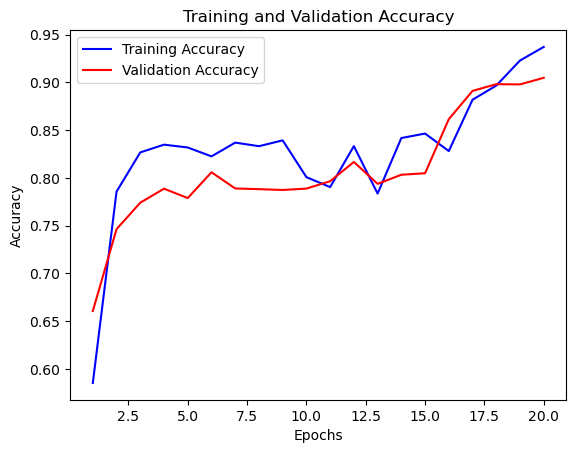

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy graph
epochs = range(1, len(train_accuracy_history) + 1)

plt.plot(epochs, train_accuracy_history, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

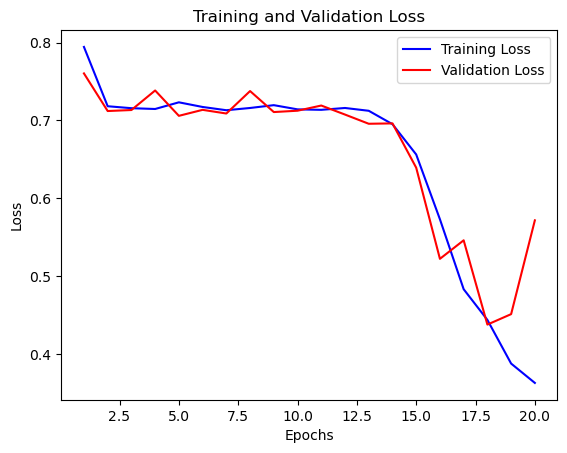

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy graph
epochs = range(1, len(train_loss_history) + 1)

plt.plot(epochs, train_loss_history, 'b', label='Training Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()